In [ ]:
%load_ext autoreload
%autoreload 2

import pathlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 

# local imports
from tools import granule
from tools import granule_name

Matplotlib is building the font cache; this may take a moment.


# Prep: get pairs of files (V2 & V3)

In [ ]:
v3files = list(pathlib.Path("/gpfs/data1/vclgp/armstonj/gedi_l4a_processing/gedi_l4a_r003_test").iterdir())
v3md = [granule_name.parse_granule_filename(f.name) for f in v3files]
v2_dir = pathlib.Path("/gpfs/data1/vclgp/data/iss_gedi/soc/2022/132")
v2f = [list(v2_dir.glob(f"GEDI04_A*{md.orbit}_{md.sub_orbit_granule}*_V002.h5")) for md in v3md]
v2files = []
for f in v2f:
    if len(f) == 2:
        if f[0] > f[1]:
            v2files.append(f[0])
        else:
            v2files.append(f[1])
    elif len(f) == 1:
        v2files.append(f[0])
    else:
        print("Error: unexpected number of files found\n", f)

file_pairs = list(zip(v2files, v3files))


In [11]:
testdir = pathlib.Path("/Users/amelia/Repos/testdata/gedi_l4a_test_granules")
v3files = sorted(list(testdir.glob("*V003.h5")))
v2files = sorted(list(testdir.glob("*V002.h5")))
file_pairs = list(zip(v2files, v3files))

for v2, v3 in file_pairs:
    md3 = granule_name.parse_granule_filename(v3.name)
    md2 = granule_name.parse_granule_filename(v2.name)
    if md2.orbit != md3.orbit or md2.sub_orbit_granule != md3.sub_orbit_granule:
        print(v2.name, v3.name)
        break
    if md2.ground_track != md3.ground_track:
        print(v2.name, v3.name)
        break
    if md2.year != md3.year or md2.julian_day != md3.julian_day:
        print(v2.name, v3.name)
        break

In [30]:
# Remove file pairs with no valid data for either version
file_pairs_filtered = []
for v2, v3 in file_pairs:
    v2_granule = granule.Granule(v2, columns=["shot_number", "agbd", "l4_quality_flag"])
    v3_granule = granule.Granule(v3, columns=["shot_number", "agbd", "l4a_quality_flag_rel3"])

    v2_cond = v2_granule.data["l4_quality_flag"] == 1
    v3_cond = np.logical_and(v3_granule.data["l4a_quality_flag_rel3"] == 1, v3_granule.data["agbd"] != -9999)
    if np.any(v2_cond) and np.any(v3_cond):
        file_pairs_filtered.append((v2, v3))
print(f"Filtered file pairs: {len(file_pairs_filtered)}")

Filtered file pairs: 48


# Step 2: Explore

### AGBD distribution -- per granule

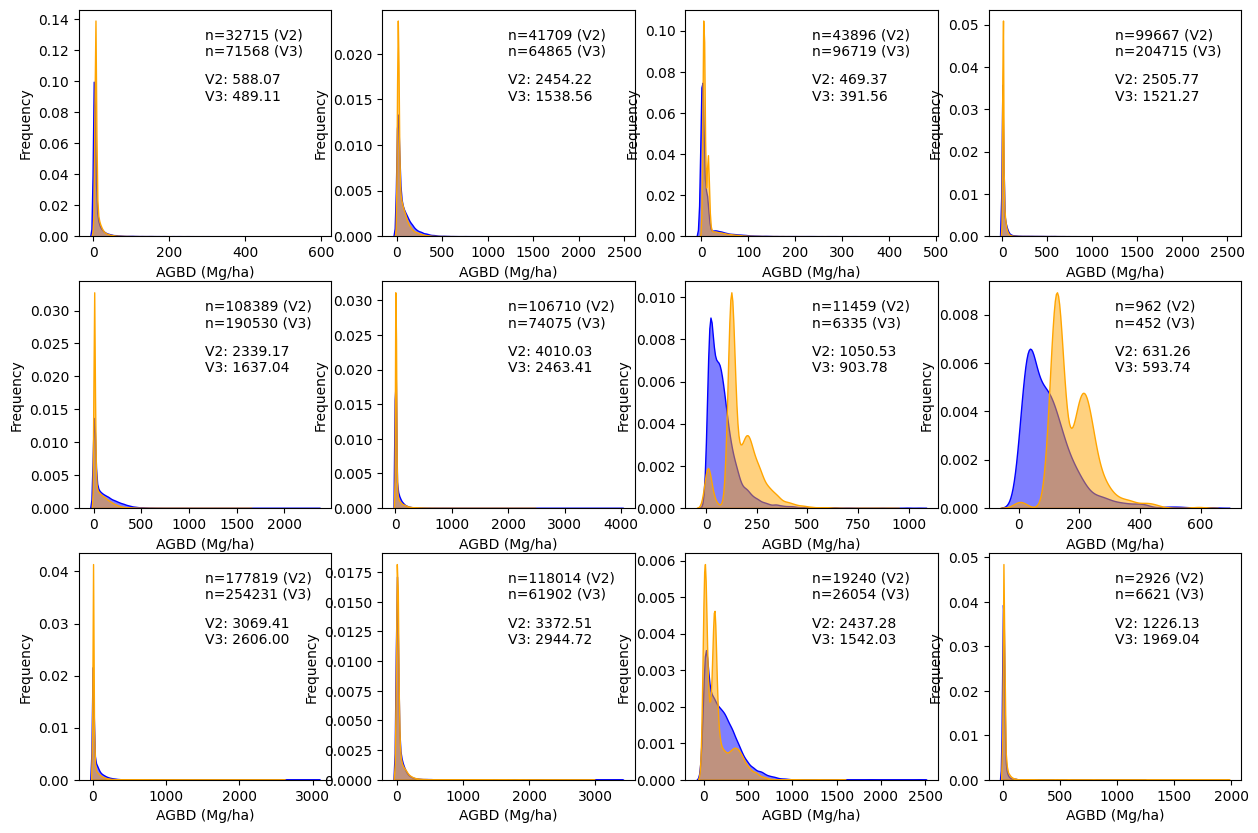

In [51]:
# View in batches of 12
batch = file_pairs_filtered[12:24]
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for i, (v2file, v3file) in enumerate(batch):
    columns = ["shot_number", "agbd", "agbd_se"]
    v2 = granule.Granule(v2file, columns=columns, quality_filter=True)
    v3 = granule.Granule(v3file, columns=columns, quality_filter=True)
    # plot the distribution of agbd for v2 and v3
    v2_agbd = v2.data["agbd"]
    v3_agbd = v3.data["agbd"]

    row = i // 4
    col = i % 4
    axi = axs[row, col]
    sns.kdeplot(v2_agbd, color="blue", fill=True, alpha=0.5, ax=axi)
    sns.kdeplot(v3_agbd, color="orange", fill=True, alpha=0.5, ax=axi)
    axi.set_xlabel("AGBD (Mg/ha)")
    axi.set_ylabel("Frequency")
    axi.text( 0.5, 0.8, f"n={len(v2_agbd)} (V2)\nn={len(v3_agbd)} (V3)", transform=axi.transAxes)
    axi.text( 0.5, 0.6, f"V2: {np.max(v2_agbd):.2f}\nV3: {np.max(v3_agbd):.2f}", transform=axi.transAxes)



### AGBD distribution -- per stratum

In [90]:
from collections import defaultdict
agbd_dist_strata2 = defaultdict(list)
agbd_dist_strata3 = defaultdict(list)

for v2file, v3file in file_pairs_filtered:
    columns = ["shot_number", "agbd", "predict_stratum"]
    v2 = granule.Granule(v2file, columns=columns, quality_filter=True)
    v3 = granule.Granule(v3file, columns=columns, quality_filter=True)
    strata2 = np.unique(v2.data["predict_stratum"])
    strata3 = np.unique(v3.data["predict_stratum"])
    if set(strata2) != set(strata3):
        print(f"Strata mismatch between V2 and V3 for {v2file.name} and {v3file.name}")
        print(set(strata2).symmetric_difference(set(strata3)))
    for stratum in strata2:
        agbd_dist_strata2[stratum].extend(v2.data[v2.data["predict_stratum"] == stratum]["agbd"])
    for stratum in strata3:
        agbd_dist_strata3[stratum].extend(v3.data[v3.data["predict_stratum"] == stratum]["agbd"])

# convert lists to numpy arrays for easier handling
for stratum in agbd_dist_strata2:
    agbd_dist_strata2[stratum] = np.array(agbd_dist_strata2[stratum])
for stratum in agbd_dist_strata3:
    agbd_dist_strata3[stratum] = np.array(agbd_dist_strata3[stratum])

# Check if the keys (strata) match between V2 and V3
if agbd_dist_strata2.keys() != agbd_dist_strata3.keys():
    print("Strata keys do not match between V2 and V3")
    print(set(agbd_dist_strata2.keys()) - set(agbd_dist_strata3.keys()))
print(len(agbd_dist_strata2.keys()))


Strata mismatch between V2 and V3 for GEDI04_A_2022132103917_O19332_02_T07641_02_003_01_V002.h5 and GEDI04_A_2022132103917_O19332_02_T07641_02_004_01_V003.h5
{b'GSW_SAs'}
Strata mismatch between V2 and V3 for GEDI04_A_2022132121207_O19333_04_T00374_02_003_01_V002.h5 and GEDI04_A_2022132121207_O19333_04_T00374_02_004_01_V003.h5
{b'DBT_SA'}
Strata mismatch between V2 and V3 for GEDI04_A_2022132151748_O19335_03_T07491_02_003_01_V002.h5 and GEDI04_A_2022132151748_O19335_03_T07491_02_004_01_V003.h5
{b'DBT_NAs'}
Strata mismatch between V2 and V3 for GEDI04_A_2022132165039_O19336_01_T03070_02_003_01_V002.h5 and GEDI04_A_2022132165039_O19336_01_T03070_02_004_01_V003.h5
{b'GSW_SA'}
Strata mismatch between V2 and V3 for GEDI04_A_2022132182329_O19337_01_T10339_02_003_01_V002.h5 and GEDI04_A_2022132182329_O19337_01_T10339_02_004_01_V003.h5
{b'EBT_SA'}
Strata mismatch between V2 and V3 for GEDI04_A_2022132230200_O19340_03_T02921_02_003_01_V002.h5 and GEDI04_A_2022132230200_O19340_03_T02921_02_004_0

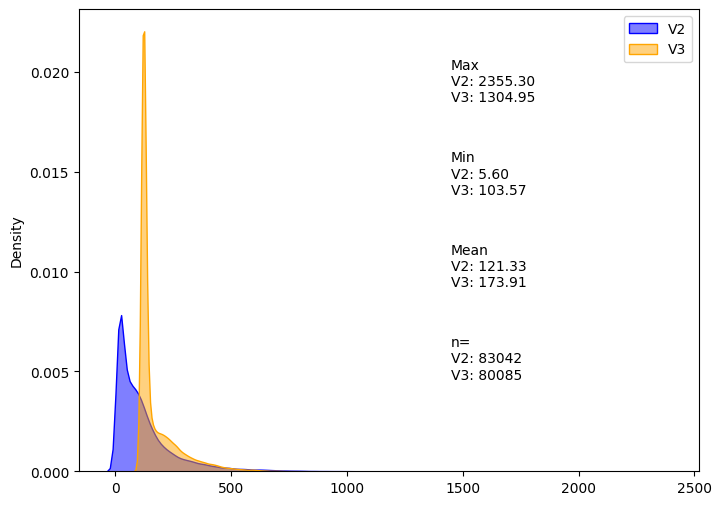

In [72]:
# Zoom in on EBT_SAs
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(agbd_dist_strata2[b'EBT_SAs'], color="blue", fill=True, alpha=0.5, ax=ax)
sns.kdeplot(agbd_dist_strata3[b'EBT_SAs'], color="orange", fill=True, alpha=0.5, ax=ax)

ax.text(0.6, 0.8, f"Max\nV2: {np.max(agbd_dist_strata2[b'EBT_SAs']):.2f}\nV3: {np.max(agbd_dist_strata3[b'EBT_SAs']):.2f}", transform=ax.transAxes)
ax.text(0.6, 0.6, f"Min\nV2: {np.min(agbd_dist_strata2[b'EBT_SAs']):.2f}\nV3: {np.min(agbd_dist_strata3[b'EBT_SAs']):.2f}", transform=ax.transAxes)
ax.text(0.6, 0.4, f"Mean\nV2: {np.mean(agbd_dist_strata2[b'EBT_SAs']):.2f}\nV3: {np.mean(agbd_dist_strata3[b'EBT_SAs']):.2f}", transform=ax.transAxes)
ax.text(0.6, 0.2, f"n=\nV2: {len(agbd_dist_strata2[b'EBT_SAs'])}\nV3: {len(agbd_dist_strata3[b'EBT_SAs'])}", transform=ax.transAxes)
ax.legend(["V2", "V3"])

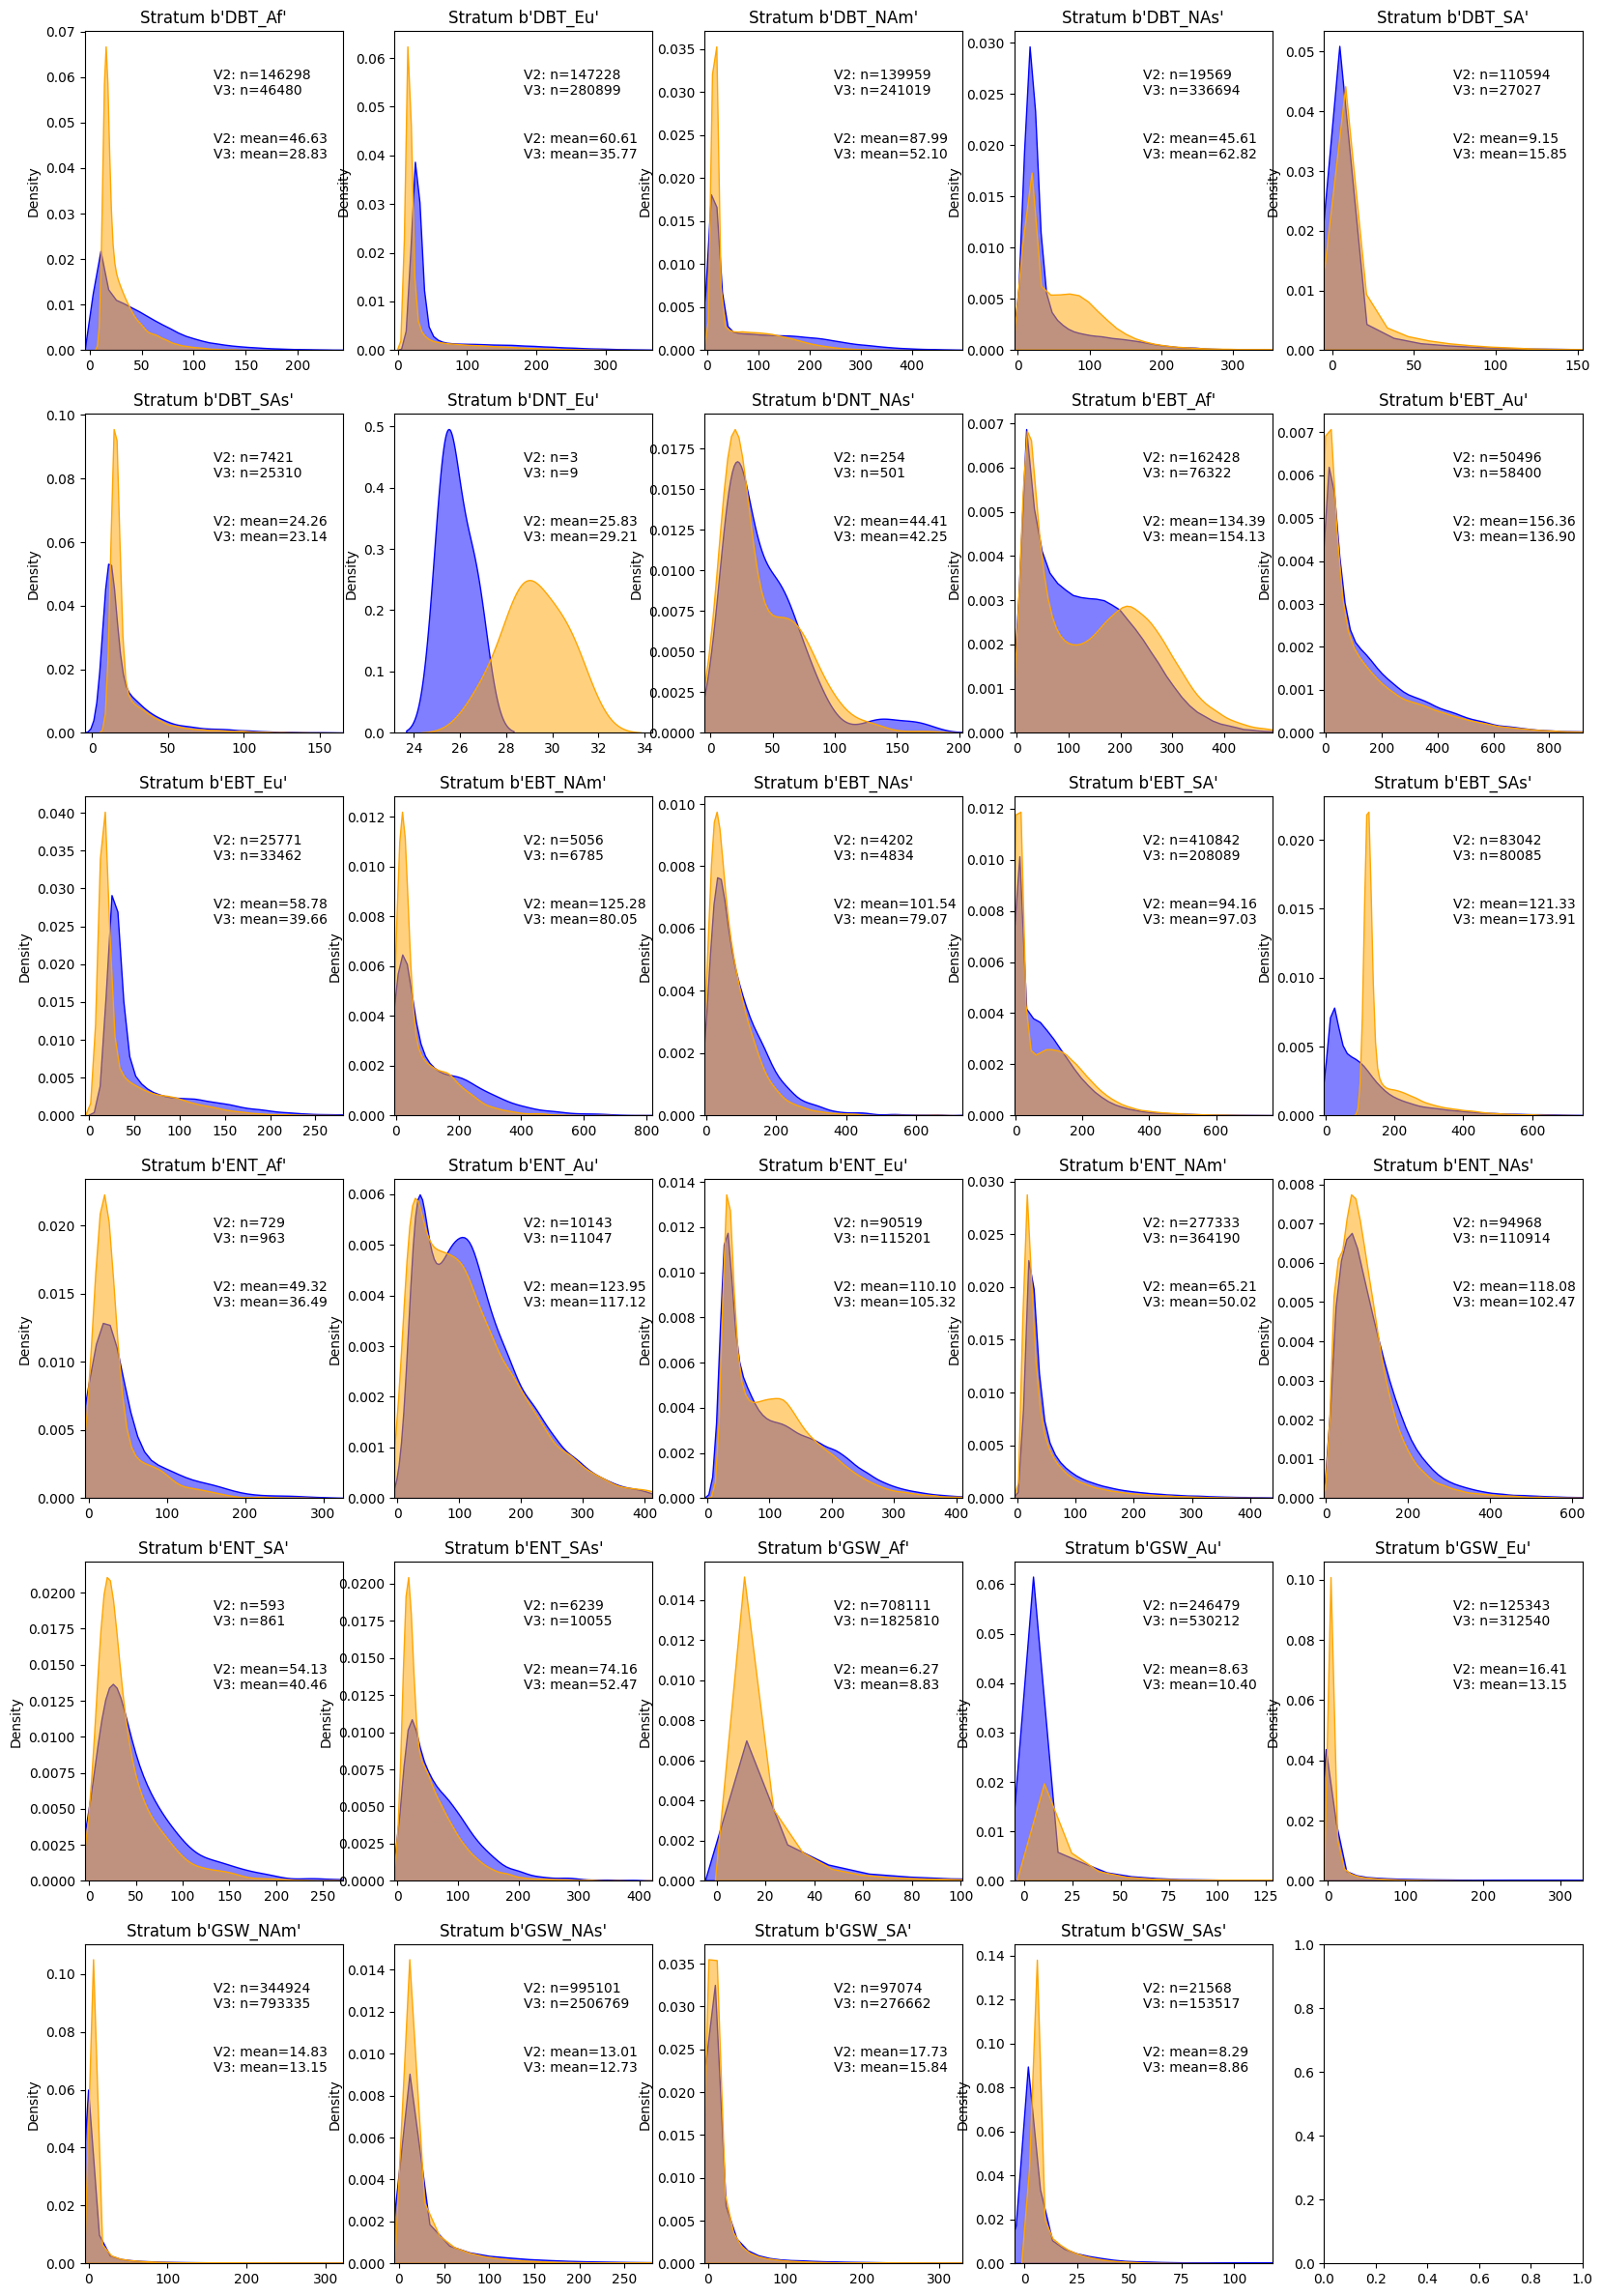

In [102]:
    
# Plot the distribution of AGBD for each stratum
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 30))
for i, stratum in enumerate(sorted(agbd_dist_strata2.keys())):
    row = i // 5
    col = i % 5
    axi = axs[row, col]
    sns.kdeplot(agbd_dist_strata2[stratum], color="blue", fill=True, alpha=0.5, ax=axi, label="V2")
    sns.kdeplot(agbd_dist_strata3[stratum], color="orange", fill=True, alpha=0.5, ax=axi, label="V3")
    if stratum != b'DNT_Eu':
        pctile_v2 = np.percentile(agbd_dist_strata2[stratum], 99.5)
        pctile_v3 = np.percentile(agbd_dist_strata3[stratum], 99.5)
        xmax = max(pctile_v2, pctile_v3)
        axi.set_xlim(-5, xmax)
    axi.set_title(f"Stratum {stratum}")
    axi.text(0.5, 0.8, f"V2: n={len(agbd_dist_strata2[stratum])}\nV3: n={len(agbd_dist_strata3[stratum])}", transform=axi.transAxes)
    axi.text(0.5, 0.6, f"V2: mean={np.mean(agbd_dist_strata2[stratum]):.2f}\nV3: mean={np.mean(agbd_dist_strata3[stratum]):.2f}", transform=axi.transAxes)


### Predict strata differ?

In [84]:
for v2f, v3f in file_pairs:
    if "O19336_04" in v2f.name or "O19337_04" in v2f.name:
        v2g = granule.Granule(v2f, columns=["shot_number", "predict_stratum"])
        v3g = granule.Granule(v3f, columns=["shot_number", "predict_stratum"])
        invalid = np.logical_and(v2g.data["predict_stratum"] == b'', v3g.data["predict_stratum"] == b'None')
        # print differences in predict_stratum
        v2ps = v2g.data["predict_stratum"][~invalid]
        v3ps = v3g.data["predict_stratum"][~invalid]
        diffs = v2ps != v3ps
        print(len(v2ps[diffs]), len(v3ps[diffs]))
        print(len(v2ps))
        print(set(v2ps[diffs]))
        print(set(v3ps[diffs]))



263 263
263
{b'EBT_Au'}
{b'EBT_SAs'}
3053 3053
3307
{b'', b'EBT_Au'}
{b'EBT_SAs', b'None'}
